In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

!pip install tensorboardx

from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append("/content/gdrive/My Drive/Colab Notebooks/DeepWololo/python_files")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

from model_trainer import ModelTrainer
from utils import *
from data_loader import *
from nn_models import LeNet
import tqdm

In [3]:
torch.__version__

'0.4.1'

In [4]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=True)
train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Use 60000 train and 10000 test samples


In [0]:
train_input = train_input.narrow(0, 0, 10000)
train_target = train_target.narrow(0, 0, 10000)

In [6]:
len(train_input)

10000

5


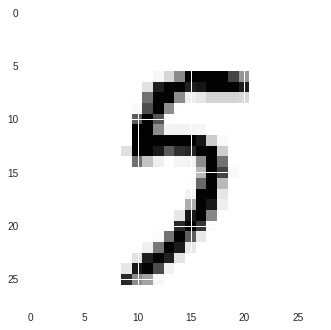

In [7]:
i = 420
plt.imshow(train_input[i, 0, :, :])
print(train_target[i].item())

## 1) LeNet F

In [0]:
def shadow_model() :
  model = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3),
      nn.ReLU(),
      nn.Conv2d(32 ,32, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Dropout(0.25),
      
      nn.Conv2d(32, 64, kernel_size=3),
      nn.ReLU(),
      nn.Conv2d(64 ,64, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Dropout(0.25),
      
      View([-1]),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 10)
  )
  return model

In [0]:
#debug_layers_dims(shadow_model(), train_input.shape)

In [0]:
train_dataset = (train_input.narrow(0, 0, 1000), train_target.narrow(0, 0, 1000))
test_dataset = (test_input.narrow(0, 0, 1000), test_target.narrow(0, 0, 1000))

in_channels = train_input.shape[1]
out_channels = 10

In [0]:
#debug_layers_dims(LeNet(), train_input.shape)

In [33]:
target_classes = np.array(train_dataset[1].tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

{0: 97, 1: 116, 2: 99, 3: 93, 4: 105, 5: 92, 6: 94, 7: 117, 8: 87, 9: 100}


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.02296019           0.144      0.00228368           0.165
10                   0.00307917           0.894      0.00030635           0.901
20                   0.00105917           0.961      0.00020690           0.935
29                   0.00059513           0.977      0.00021483           0.934
*******************************************************************************


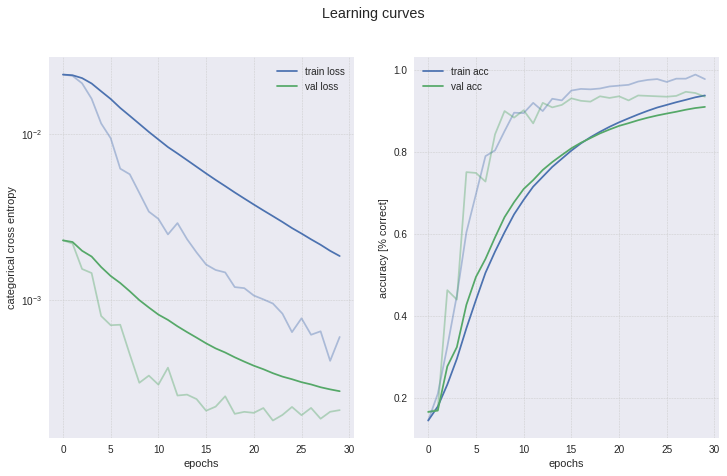

In [34]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

net = shadow_model()
loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.1

mt = ModelTrainer(net, loss_fun, optim.SGD(net.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=30, batch_size=100, verbose=10)
mt.plot_training("Learning curves")

##1.2) 10F


training shadow model [0] ...done !
training shadow model [1] ...done !
training shadow model [2] ...done !
training shadow model [3] ...done !
training shadow model [4] ...done !
training shadow model [5] ...done !
training shadow model [6] ...done !
training shadow model [7] ...done !
training shadow model [8] ...done !
training shadow model [9] ...done !


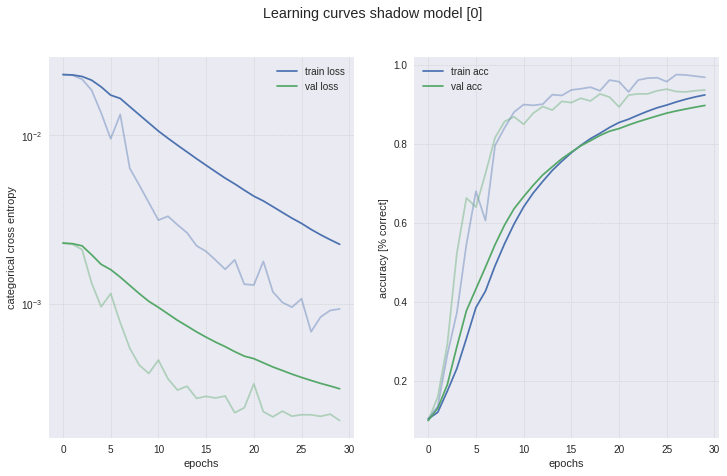

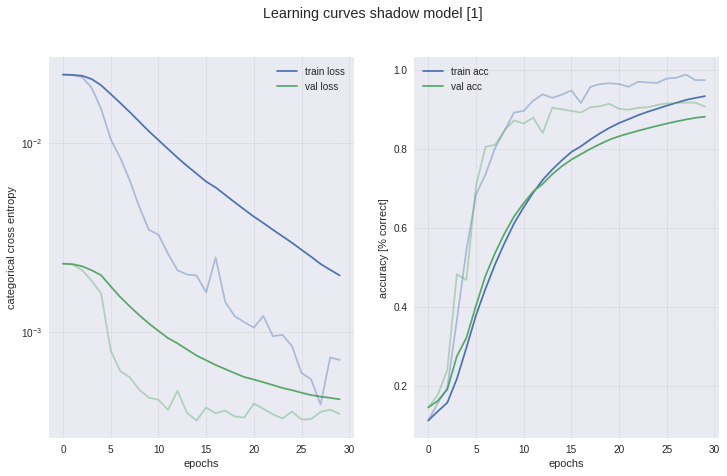

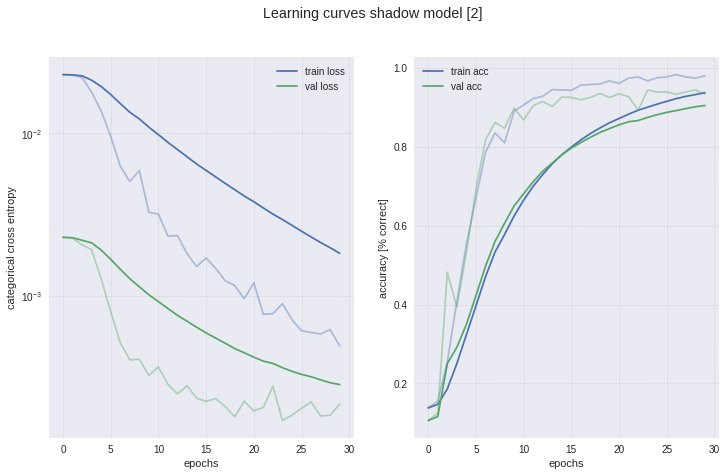

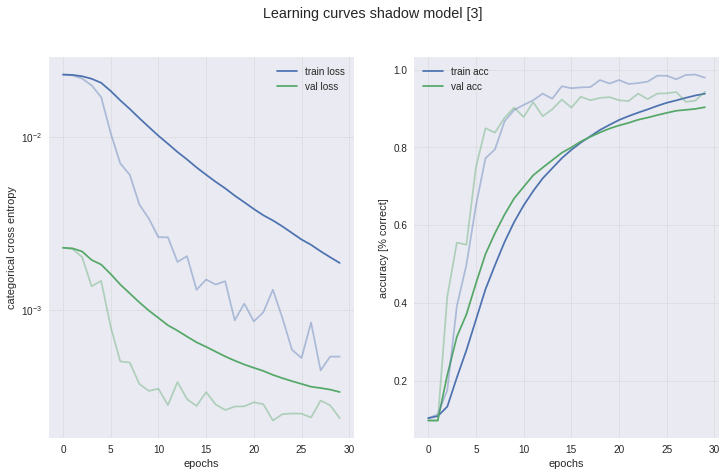

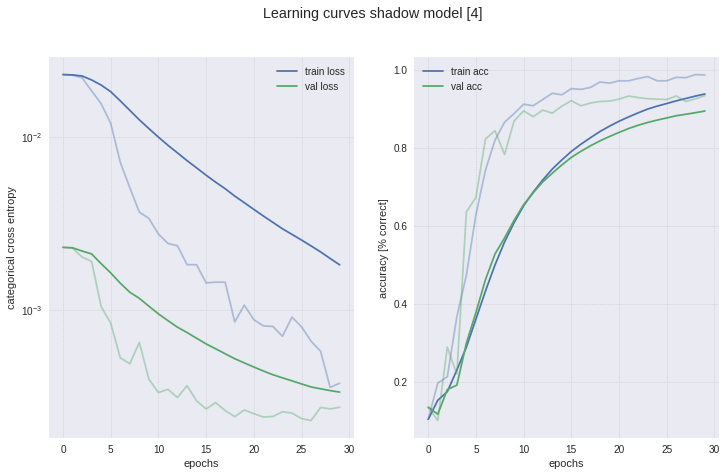

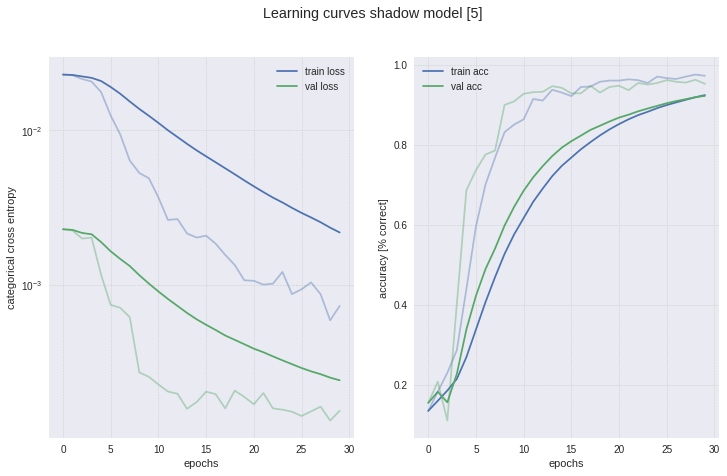

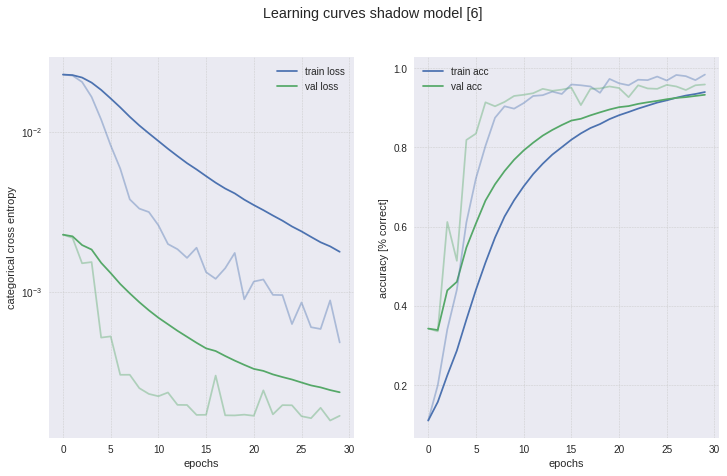

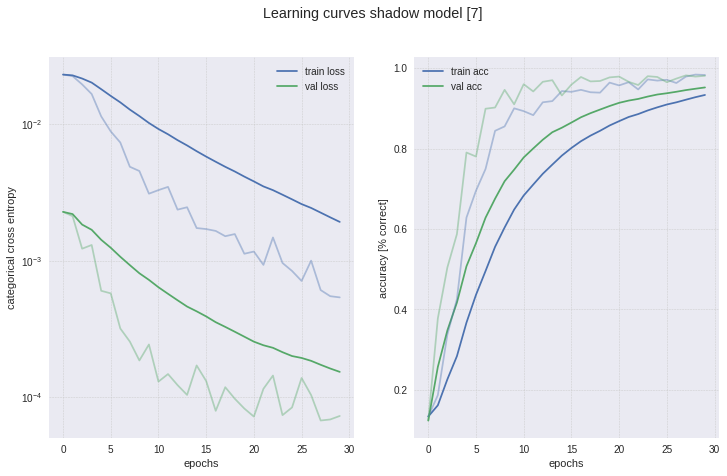

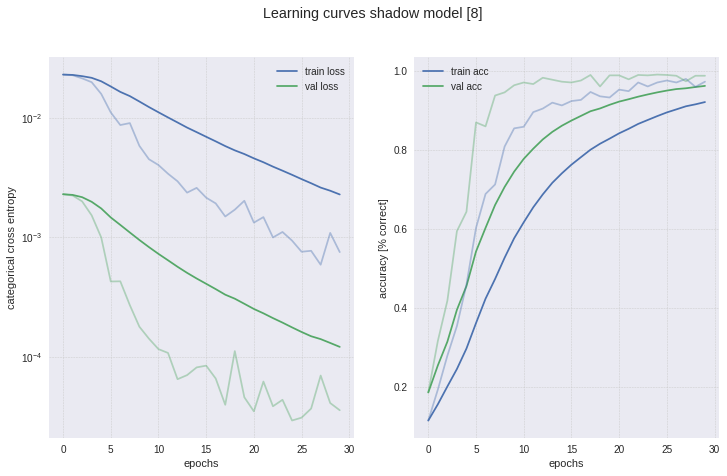

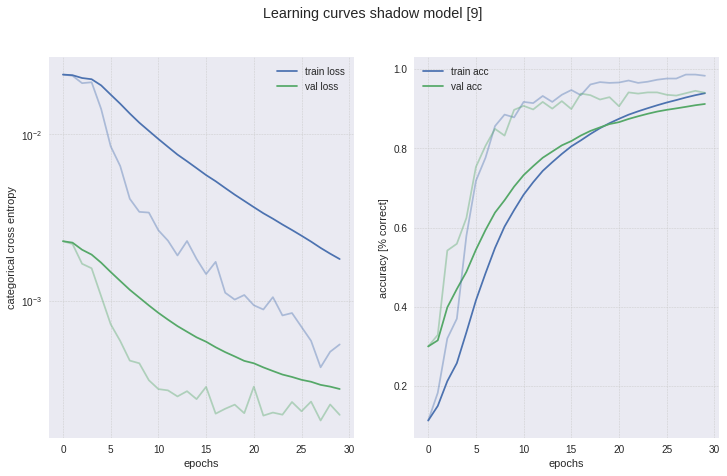

In [13]:
(shadow_train_datasets, shadow_test_datasets) = generate_n_shadow_models_datasets(10, train_dataset, test_dataset)

#Define training parameters
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
learning_rate = 0.1
nb_epochs = 30
batch_size = 100
verbose = 0

#create the shadow models
model_class = shadow_model
shadow_models = list()
for i in range(10):
    shadow_models.append(model_class())
    
#train the shadow models
for i in range(10):
    print("training shadow model ["+str(i)+"] ...", end='')

    crossEntropyClassesWeigths = computeClassesWeights(shadow_train_datasets[i][1])

    loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)

    mt = ModelTrainer(shadow_models[i], loss_fun, optim.SGD(shadow_models[i].parameters(), lr=learning_rate), y_hat_fun, crit_fun)
    hist = mt.fit(shadow_train_datasets[i], shadow_test_datasets[i], epochs=nb_epochs, batch_size=batch_size, verbose=verbose)
    mt.plot_training("Learning curves shadow model ["+str(i)+"]")
    print("done !")


## 2) Net G

## Net def

In [0]:
def kindaResnetG(layer_dim):
  dim = layer_dim[2]
  pad = (1, 1, 1)
  pool = 1
  finalVectorSize = layer_dim[2]//pool * layer_dim[3]//pool * layer_dim[4]//pool
  model = nn.Sequential(
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ReLU(),
      #nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ReLU(),
      #nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ReLU(),
      #nn.BatchNorm3d(1),
      #nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      #nn.ReLU(),
      #nn.MaxPool3d(pool),
      
      View([-1]),
      nn.Linear(finalVectorSize, 64),
      nn.ReLU(),
      #nn.Linear(64, 128),
      #nn.ReLU(),
      nn.Linear(64, 256),
      nn.ReLU(),
      nn.Linear(256, 256),
      nn.ReLU(),
      nn.Linear(256, 2),
      
  )
  return model

def aliGs(vector_size):
    finalVectorSize = (((((vector_size-7)//2)-4)//2)-2)//2
    
    model = nn.Sequential(
        nn.Conv1d(1, 32, kernel_size = 8),
        nn.RReLU(),
        nn.BatchNorm1d(32),
        nn.MaxPool1d(kernel_size = 2),
        
        nn.Conv1d(32, 64, kernel_size = 5),
        nn.RReLU(),
        nn.BatchNorm1d(64),
        nn.MaxPool1d(kernel_size = 2),
        
        nn.Conv1d(64, 16, kernel_size = 3),
        nn.RReLU(),
        nn.BatchNorm1d(16),
        nn.MaxPool1d(kernel_size = 2),
        
        View([-1]),
        nn.Linear(16* finalVectorSize, 100),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(100, 32),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(32, 2)
    )
    
    return model
  
def daAliG(vector_size):
    finalVectorSize = (((((vector_size-7)//2)-4)//2)-2)//2
    
    model = nn.Sequential(
        nn.Conv1d(1, 256, kernel_size = 8, stride=1),
        nn.RReLU(),
        nn.BatchNorm1d(256),
        nn.MaxPool1d(kernel_size = 2),
        
        nn.Conv1d(256, 128, kernel_size = 5),
        nn.RReLU(),
        nn.BatchNorm1d(128),
        nn.MaxPool1d(kernel_size = 2),
        
        nn.Conv1d(128, 16, kernel_size = 3),
        nn.RReLU(),
        nn.BatchNorm1d(16),
        nn.MaxPool1d(kernel_size = 2),
        
        View([-1]),
        nn.Linear(16* finalVectorSize, 128),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(128, 128),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(128, 32),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(32, 2)
    )
    
    return model
  
def denseG(vector_size):
    model = nn.Sequential(
        View([-1]),
        nn.Linear(vector_size, 128),
        nn.RReLU(),
        nn.Dropout(0.3),
        
        nn.Linear(128, 128),
        nn.RReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(128, 2),
    )
    return model

In [0]:
#debug_layers_dims(kindaResnetG(g_train_dataset[0].shape), g_train_dataset[0].shape)

## Playground n=1

In [0]:
label = 5
idx = train_dataset[1] == label
label_train_dataset = (train_dataset[0][idx], train_dataset[1][idx])
idx = test_dataset[1] == label
label_test_dataset = (test_dataset[0][idx], test_dataset[1][idx])

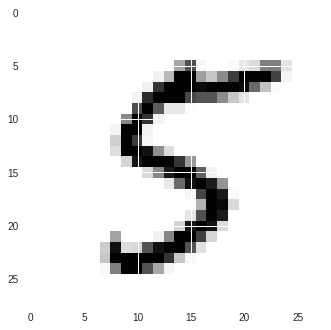

In [14]:
i = 10
plt.imshow(label_test_dataset[0][i, 0, :, :])

In [42]:
net0 = shadow_models[0]
net0

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.25)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.25)
  (12): View(_, [-1])
  (13): Linear(in_features=1024, out_features=512, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5)
  (16): Linear(in_features=512, out_features=10, bias=True)
)

In [0]:
(g_train_input, g_train_target), (g_test_input, g_test_target) = \
generate_dataset_g(net, train_dataset, test_dataset, [net[8]], ['conv'], split=0.8, full=True)

g_train_target = g_train_target.long()
g_test_target = g_test_target.long()

g_train_dataset = (g_train_input, g_train_target)
g_test_dataset = (g_test_input, g_test_target)  

In [37]:
g_train_input.shape

torch.Size([1600, 1, 64, 8, 8])

In [38]:
size_input_vector = g_train_dataset[0].shape#[2]
print("size of layer vector :", size_input_vector)

size of layer vector : torch.Size([1600, 1, 64, 8, 8])


In [39]:
g_train_dataset[1].shape[0]

1600

In [40]:
target_classes = np.array(g_train_dataset[1].tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

{0: 800, 1: 800}


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00693702           0.487      0.00173057           0.500
10                   0.00604555           0.672      0.00151590           0.675
20                   0.00504077           0.744      0.00182176           0.632
30                   0.00234559           0.904      0.00259538           0.627
40                   0.00647755           0.863      0.00250706           0.635
50                   0.00279727           0.946      0.00361083           0.613
60                   0.00042216           0.993      0.00670203           0.672
70                   0.00000513           1.000      0.00911738           0.662
80                   0.00000319           1.000      0.00994881           0.662
90                   0.00000140           1.000      0.01065038           0.662
99                   0.00000101         

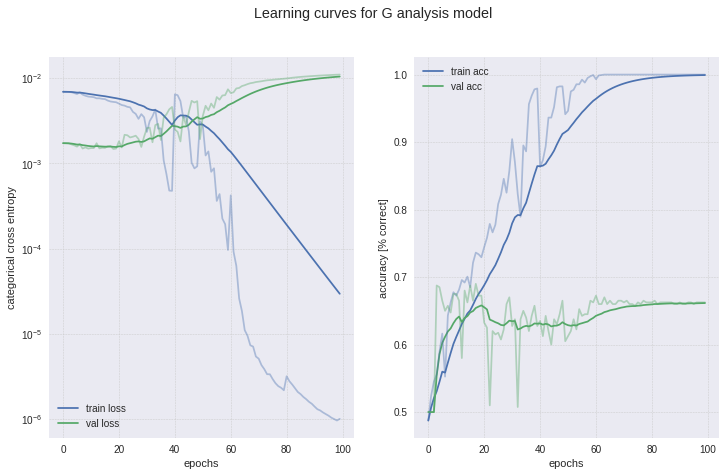

In [41]:
modelG = kindaResnetG(size_input_vector)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
batch_cap = 40
batch_fun = lambda x, y: x // (y // batch_cap + 1) #x: batch_size, y: epoch

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.1

mt = ModelTrainer(modelG, loss_fun, optim.SGD(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun, batch_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=100, batch_size=100, verbose=10)
mt.plot_training("Learning curves for G analysis model")

## Playground n = 10

In [0]:
def generate_dataset_g_per_class_from_shadows(models, train_dataset, test_dataset, layers, layer_names, split=0.7, full=True):
    """
    Generate the dataset for g with the values spied from the given layers for each models as input and the
    labels taking value '1' if the original data was part of the train set, '0' otherwise. 
    The generated datasets are separated by classes, ie. if your original training/testing
    data had n target classes, this function will return two lists (train and test) of n 
    components, with the i-th component being the train or test dataset for the i-th 
    target class.
    Args:
    -models : Array containing the models to spy
    -train_dataset: original train dataset
    -test_dataset: original test dataset
    -layers: Array of array containing the model layers to spy on
    -layer_name: Array of array containing the names of the layer, to be used as keys in the returned
    -split: Percentage of data to keep for the new train dataset
    Returns:
    -list of n new train datasets
    -list of n new test dataset
    """
    train_input, train_target = train_dataset
    test_input, test_target = test_dataset
    
    target_classes = torch.unique(train_target, sorted=True)

    train_mask_classes = [train_target == c for c in target_classes]
    test_mask_classes = [test_target == c for c in target_classes]

    train_dataset_classes = [(train_input[mask], train_target[mask]) for mask in train_mask_classes]
    test_dataset_classes = [(test_input[mask], test_target[mask]) for mask in test_mask_classes]
    
    g_train_dataset_classes = list()
    g_test_dataset_classes = list()

    for c in target_classes:
        g_train_input_full = None
        g_train_target_full = None
        g_test_input_full = None
        g_test_target_full = None

        for i, net in enumerate(models):
            (g_train_input, g_train_target), (g_test_input, g_test_target) = \
            generate_dataset_g(net, train_dataset_classes[c], test_dataset_classes[c], layers[i], layer_names[i], split=split, full=full)

            g_train_target = g_train_target.long()
            g_test_target = g_test_target.long()

            if g_train_input_full is None:
                g_train_input_full = g_train_input
                g_train_target_full = g_train_target
                g_test_input_full = g_test_input
                g_test_target_full = g_test_target
            else:
                g_train_input_full = torch.cat((g_train_input_full,g_train_input), 0)
                g_train_target_full = torch.cat((g_train_target_full, g_train_target), 0)
                g_test_input_full = torch.cat((g_test_input_full, g_test_input), 0)
                g_test_target_full = torch.cat((g_test_target_full, g_test_target), 0)

        (tmp1, tmp2) = (g_train_input_full, g_train_target_full), (g_test_input_full, g_test_target_full)
            
        g_train_dataset_classes.append(tmp1)
        g_test_dataset_classes.append(tmp2)
        
    return g_train_dataset_classes, g_test_dataset_classes




In [0]:
layers = [[l[8]] for l in shadow_models]
layer_names = [['conv'] for l in shadow_models]
g_train_dataset_classes, g_test_dataset_classes = generate_dataset_g_per_class_from_shadows(shadow_models, train_dataset, test_dataset, layers, layer_names, split=0.7, full=True)

*************** Class 0 ********************
size of layer vector : torch.Size([1260, 1, 64, 8, 8])
repartition of labels : {0: 590, 1: 670}
******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00706909           0.532      0.00121123           0.536
10                   0.00628424           0.638      0.00099244           0.707
20                   0.00551179           0.719      0.00123607           0.623
30                   0.00484168           0.793      0.00182833           0.645
40                   0.00771634           0.848      0.00171807           0.605
50                   0.00306948           0.943      0.00406763           0.605
60                   0.00071378           0.988      0.00547254           0.579
70                   0.00000278           1.000      0.00797872           0.589
80                   0.00000171           1.000      0.0087

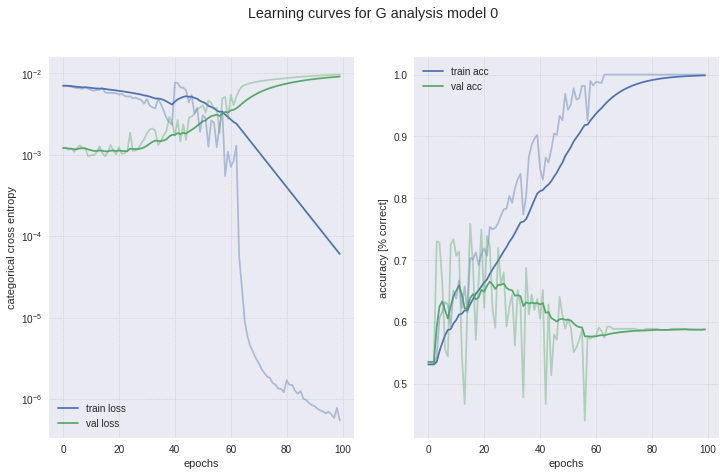

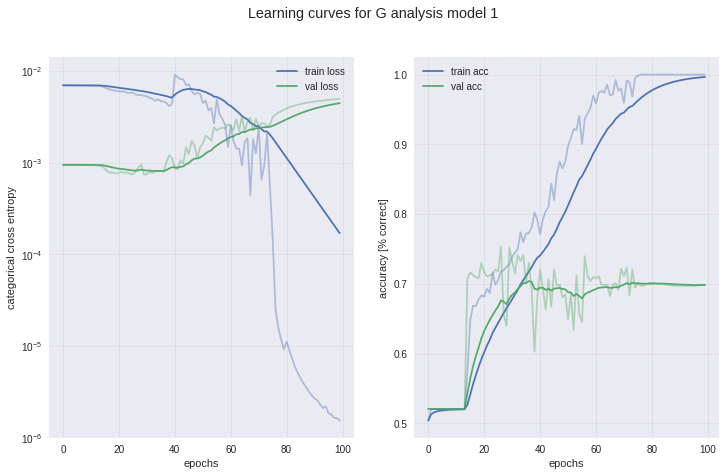

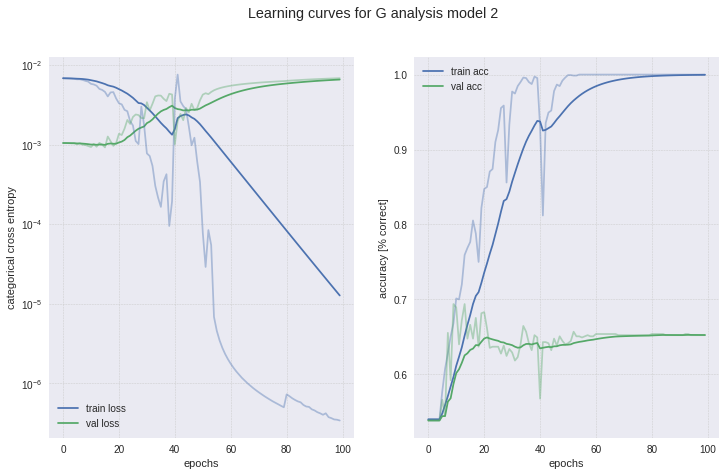

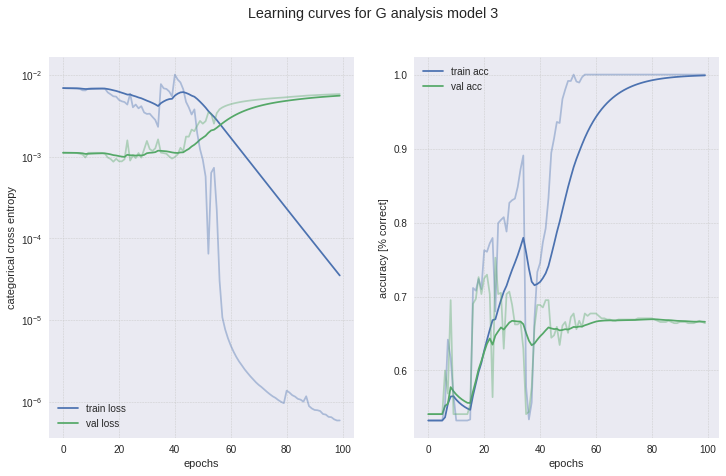

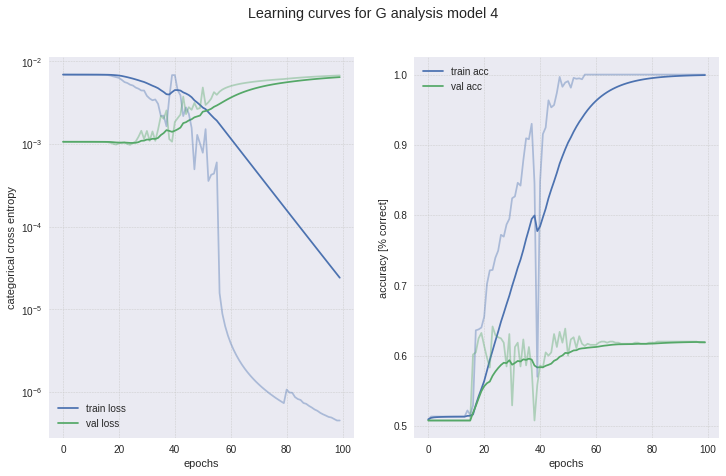

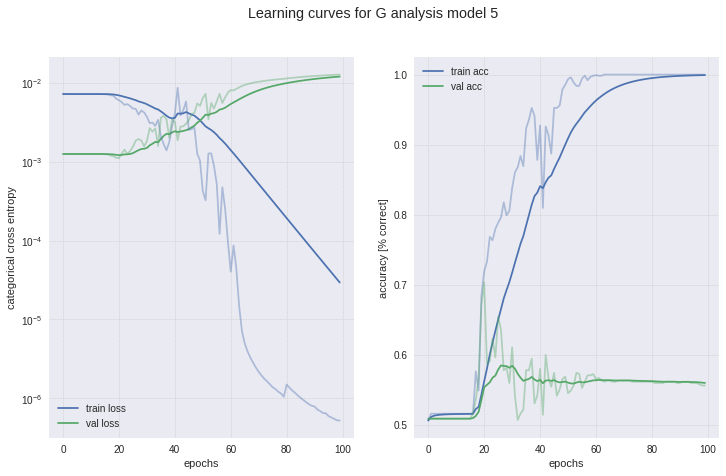

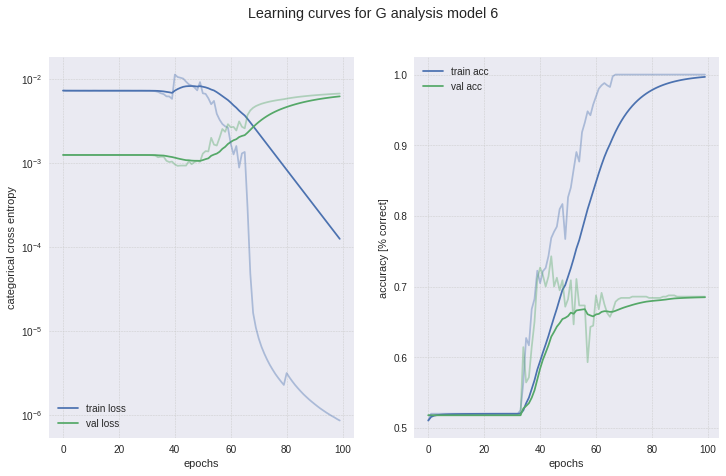

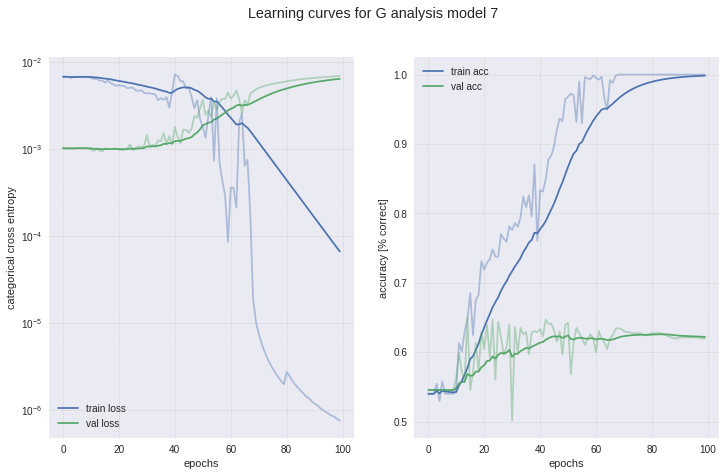

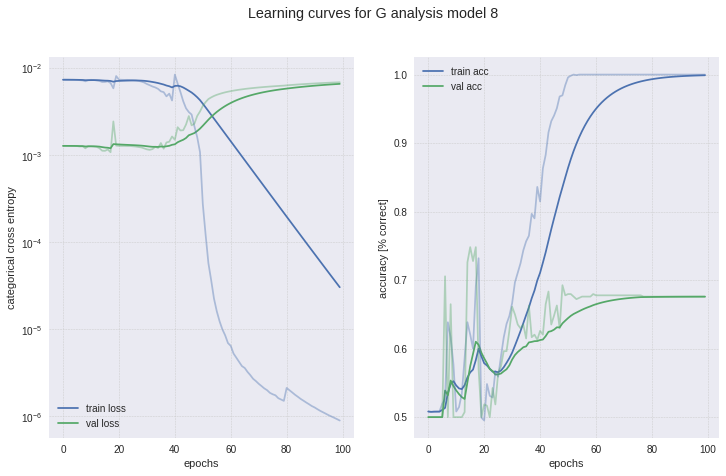

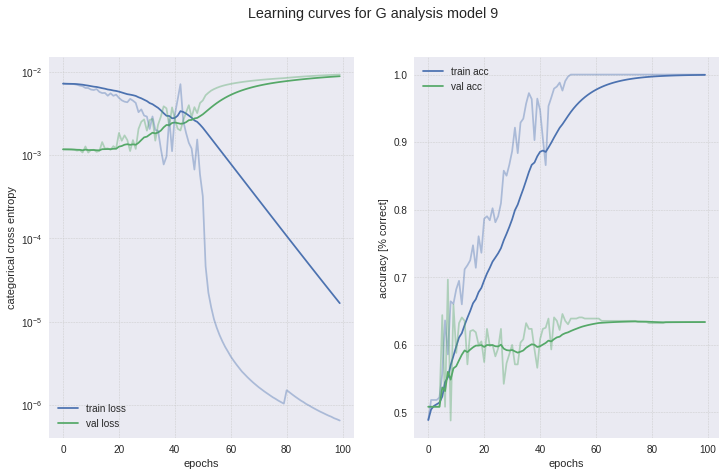

In [49]:
for i in range(10):
    g_train_dataset = g_train_dataset_classes[i]
    g_test_dataset = g_test_dataset_classes[i]
    
    size_input_vector = g_train_dataset[0].shape#[2]
    print('*************** Class {} ********************'.format(i))
    print("size of layer vector :", size_input_vector)
    
    target_classes = np.array(g_train_dataset[1].tolist())
    unique, counts = np.unique(target_classes, return_counts=True)

    print("repartition of labels :", dict(zip(unique, counts)))
    crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

    modelG = kindaResnetG(size_input_vector)

    crit_fun = lambda input_, target : (input_, target)
    y_hat_fun = lambda y: y.argmax(1)
    batch_cap = 40
    batch_fun = lambda x, y: x // (y // batch_cap + 1) #x: batch_size, y: epoch

    loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
    learning_rate = 0.1

    mt = ModelTrainer(modelG, loss_fun, optim.SGD(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun, batch_fun)
    hist = mt.fit(g_train_dataset, g_test_dataset, epochs=100, batch_size=100, verbose=10)
    mt.plot_training("Learning curves for G analysis class {}".format(i))